# Transform WAV files to Frequency Domain

In [2]:
import os

import torch
import torchaudio.functional
from torch.utils.data import DataLoader
import numpy as np

from src.data import WaveDataset, SpectrogramDataset
from src.features import WaveProcessor, WaveProcessorConfig
from src.visualization import plot_spectrogram, plot_waveform
import matplotlib.pyplot as plt

wdir = os.getcwd().replace("\\", "/") + "/.."
processed_dir = f"{wdir}/data/processed/musicnet"
output_dir = f"{wdir}/data/output/musicnet"
print(f"Working Directory: {wdir}")
print(f"Processed Directory: {processed_dir}")

Working Directory: D:/lyx20/Documents/LiuYuxuan/universite/Year4/csc413/a2a-music-gen/notebooks/..
Processed Directory: D:/lyx20/Documents/LiuYuxuan/universite/Year4/csc413/a2a-music-gen/notebooks/../data/processed/musicnet


In [16]:
sr = 44100 // 8

Batch 0: x.shape=torch.Size([2, 264576]), y.shape=torch.Size([2, 66144])
1727.wav


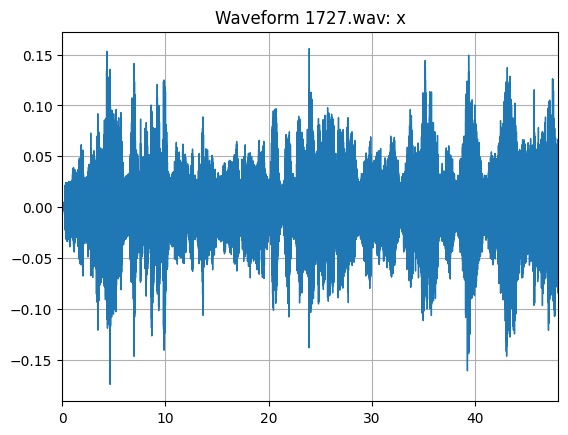

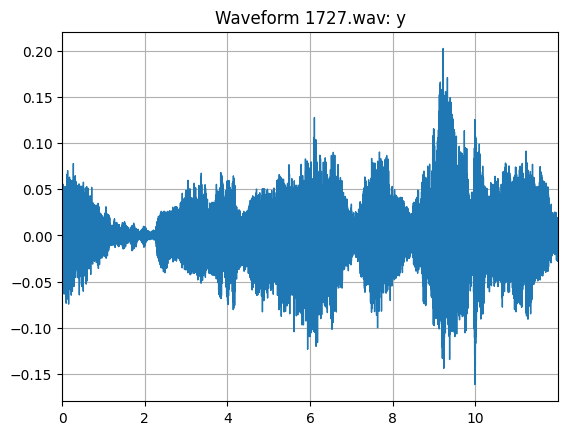

torch.Size([201, 1323])
torch.Size([201, 331])


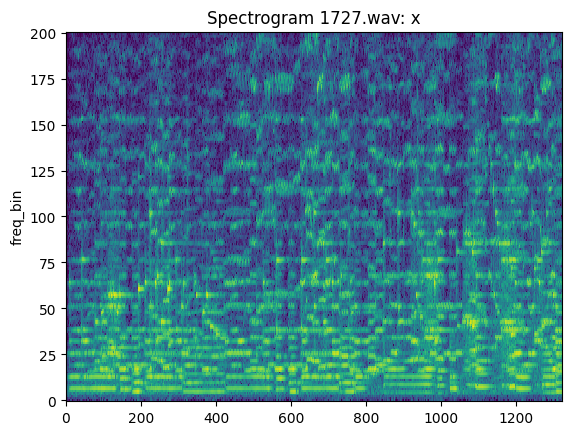

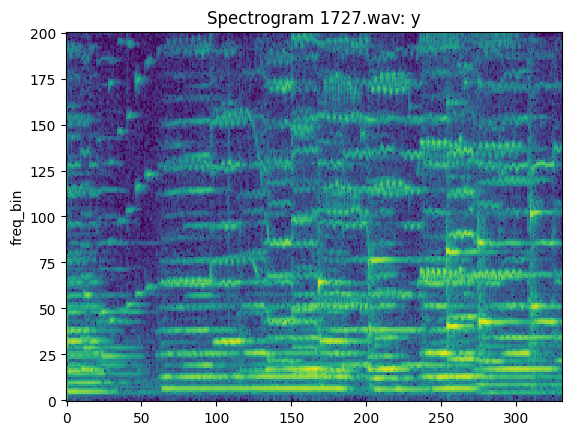

1728.wav


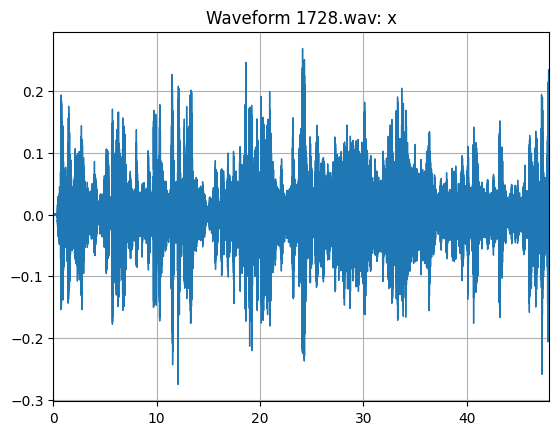

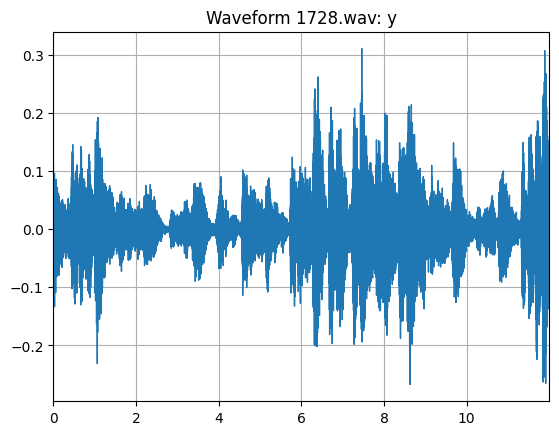

torch.Size([201, 1323])
torch.Size([201, 331])


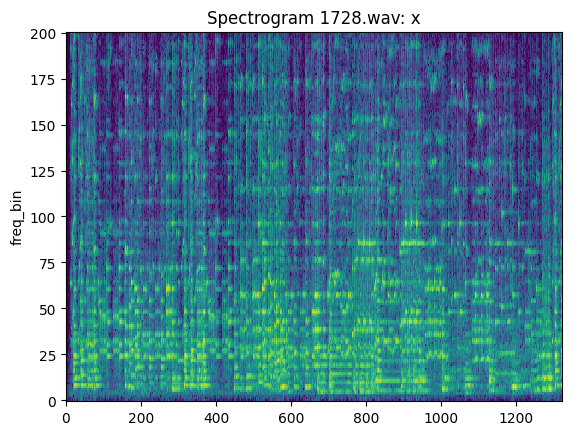

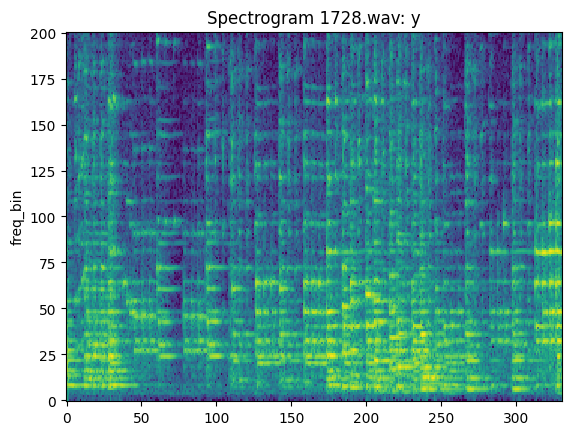

In [17]:
wav_dataset = WaveDataset(f"{wdir}/data/raw/musicnet/train_data", sr=sr)
wpconfig = WaveProcessorConfig(sr=sr)
wp = WaveProcessor(wpconfig)

wav_loader = DataLoader(wav_dataset, batch_size=2, shuffle=False)
for b, (xs, ys, fnames) in enumerate(wav_loader):
    print(f"Batch {b}: x.shape={xs.shape}, y.shape={ys.shape}")
    for x, y, fname in zip(xs, ys, fnames):
        print(f"{fname}")
        if b % 20 == 0:
            plot_waveform(x, sr, title=f"Waveform {fname}: x")
            plot_waveform(y, sr, title=f"Waveform {fname}: y")

        input_spec = wp.wav2freq(x)
        print(input_spec.shape)
        label_spec = wp.wav2freq(y)
        print(label_spec.shape)

        if b % 20 == 0:
            plot_spectrogram(input_spec, title=f"Spectrogram {fname}: x")
            plot_spectrogram(label_spec, title=f"Spectrogram {fname}: y")

        SpectrogramDataset.save(input_spec, f"{processed_dir}/train_data", fname)
        SpectrogramDataset.save(
            label_spec, f"{processed_dir}/train_labels", fname, is_label=True
        )
        SpectrogramDataset.save_metadata(
            wpconfig.to_dict(), f"{processed_dir}/train_meta", fname
        )

    print("====================================")
    if b == 0:
        break

In [19]:
import torchaudio.functional as F
spec_dataset = SpectrogramDataset(
    f"{processed_dir}/train_data", label_dir=f"{processed_dir}/train_labels"
)
spec_loader = DataLoader(spec_dataset, batch_size=2, shuffle=False)

for b, (xs, ys, fnames) in enumerate(spec_loader):
    print(f"Batch {b}")
    for x, y, fname in zip(xs, ys, fnames):
        print(f"{fname}")
        if b % 20 == 0:
            plot_spectrogram(x, title=f"Spectrogram {fname}: x")
            plot_spectrogram(y, title=f"Spectrogram {fname}: y")
            
        # Transform back to waveform
        x_wave = wp.freq2wav(x)
        y_wave = wp.freq2wav(y)
        print(x_wave.shape, y_wave.shape)
        
        if b % 20 == 0:
            plot_waveform(x_wave, sr, title=f"Waveform {fname}: x")
            plot_waveform(y_wave, sr, title=f"Waveform {fname}: y")
            
        # Save to WAV file
        WaveDataset.save(x_wave, sr, f"{output_dir}/train_data", f"{fname}.x")
        WaveDataset.save(y_wave, sr, f"{output_dir}/train_data", f"{fname}.y")

    print("====================================")
    if b == 0:
        break

Batch 0
1727.wav.x.npy
torch.Size([1, 264400]) torch.Size([1, 66000])
Saving to D:/lyx20/Documents/LiuYuxuan/universite/Year4/csc413/a2a-music-gen/notebooks/../data/output/musicnet/train_data\1727.wav.x.npy.x.wav
Saving to D:/lyx20/Documents/LiuYuxuan/universite/Year4/csc413/a2a-music-gen/notebooks/../data/output/musicnet/train_data\1727.wav.x.npy.y.wav
1728.wav.x.npy
torch.Size([1, 264400]) torch.Size([1, 66000])
Saving to D:/lyx20/Documents/LiuYuxuan/universite/Year4/csc413/a2a-music-gen/notebooks/../data/output/musicnet/train_data\1728.wav.x.npy.x.wav
Saving to D:/lyx20/Documents/LiuYuxuan/universite/Year4/csc413/a2a-music-gen/notebooks/../data/output/musicnet/train_data\1728.wav.x.npy.y.wav


In [ ]:
import IPython.display as ipd
ipd.Audio(f"{output_dir}/train_data/1727.x.wav")